# Titanic: Sera q eu morreria ?

In [1]:
#Bibliotecas Utilizadas

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from torch.utils.data import TensorDataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time, copy

In [2]:
# Importando o Dataset e adequando a base.

titanic_df = pd.read_csv('Dados/Titanic.csv')

# "Dumizando" a coluna Sex para ter um valor numerico final e convertendo o mesmo para 0 e 1
titanic_df = pd.get_dummies(titanic_df, columns=['Sex'], prefix='Sex')

titanic_df['Sex_female'] = (titanic_df['Sex_female'] == True).astype(int)
titanic_df['Sex_male'] = (titanic_df['Sex_male'] == True).astype(int)

# Olhando o Dataset, vejo que uma coluna relevante, como Idade, tem 263 NaN, então vou dropar esses valores da base final.
qtd_nans_por_coluna = titanic_df.isna().sum()
print(qtd_nans_por_coluna)

# Drop de NaN na idade
titanic_df = titanic_df.dropna(subset=['Age'])

# Para montar a base, vou selecionar as colunas abaixo que considero relevante para a sobrevivencia, Classe, Sexo, Idade, Num de Filhos, Parceiro, e se sobreviveu como saída
colunas_selecionadas = ['Pclass', 'Sex_female', 'Sex_male', 'Age', 'SibSp','Parch','Survived']

# Cria um novo DataFrame contendo apenas as colunas selecionadas
df = titanic_df[colunas_selecionadas]

df

PassengerId       0
Survived          0
Pclass            0
Name              0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Sex_female        0
Sex_male          0
dtype: int64


,Pclass,Sex_female,Sex_male,Age,SibSp,Parch,Survived
0,3,0,1,22.0,1,0,0
1,1,1,0,38.0,1,0,1
2,3,1,0,26.0,0,0,1
3,1,1,0,35.0,1,0,1
4,3,0,1,35.0,0,0,0
...,...,...,...,...,...,...,...
1300,3,1,0,3.0,1,1,1
1302,1,1,0,37.0,1,0,1
1303,3,1,0,28.0,0,0,1
1305,1,1,0,39.0,0,0,1


In [3]:
# Separando as colunas entre features (Os valores X de entrada) e o label (Valor Y de saída)
numerical_feature_columns = ['Pclass', 'Sex_female', 'Sex_male', 'Age', 'SibSp','Parch','Survived']
label_column = 'Survived'

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

def train_test_val_split(df, feature_columns, label_column, ct):
  # Primeiro, realizar uma divisão de treinamento/teste de 80/20
  initial_train_split = df.sample(frac=.8,random_state=42)
  test = df.drop(initial_train_split.index)

  # Em seguida, realizar uma divisão de treinamento/validação de 75/25
  train = initial_train_split.sample(frac=.75, random_state=42)
  val = initial_train_split.drop(train.index)

  # Separar todos os conjuntos de dados em atributos e rótulos (x e y)
  train_x = train[feature_columns]
  # Não será realizada transformação nos rótulos, então podem ser convertidos diretamente em tensores torch
  train_y = torch.from_numpy(train[label_column].values)

  val_x = val[feature_columns]
  val_y = torch.from_numpy(val[label_column].values)

  test_x = test[feature_columns]
  test_y = torch.from_numpy(test[label_column].values)

  # Ajustar o ColumnTransformer ao conjunto de dados de treinamento
  ct.fit(train_x)

  # Realizar a padronização em cada um dos conjuntos de dados x
  train_x = ct.transform(train_x)
  val_x = ct.transform(val_x)
  test_x = ct.transform(test_x)

  # Transformar nossos conjuntos de dados em tensores torch
  train_x = torch.from_numpy(train_x).float()
  val_x = torch.from_numpy(val_x).float()
  test_x = torch.from_numpy(test_x).float()

  # Criar os conjuntos de dados de entrada-rótulo para serem consumidos pelo PyTorch
  train_dataset = TensorDataset(train_x, train_y)
  test_dataset = TensorDataset(test_x, test_y)
  val_dataset = TensorDataset(val_x, val_y)
  return train_dataset, test_dataset, val_dataset


In [5]:
# Criar nosso StandardScaler para ser usado na padronização dos dados
# Mais informações aqui: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer
ct = ColumnTransformer([('numerical_features', StandardScaler(), numerical_feature_columns)], remainder='passthrough')

train_dataset, test_dataset, val_dataset = train_test_val_split(df, numerical_feature_columns, label_column, ct)

In [6]:
# Configuração do dispositivo (treinar nosso modelo na GPU se estiver disponível, o que é muito mais rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hiperparâmetros

# Arquitetura do modelo
input_size = len(numerical_feature_columns) # Garantir a remoção da coluna de index
hidden_size1 = 10
hidden_size2 = 10
hidden_size3 = 10
num_classes = 2

# Parâmetros externos de treinamento
batch_size = 10
learning_rate = 0.001
num_epochs = 50


In [7]:
# Modelo de classificação simples com duas camadas ocultas
class SimpleClassifier1Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, num_classes):
        super(SimpleClassifier1Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

# Modelo de classificação simples com duas camadas ocultas
class SimpleClassifier2Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(SimpleClassifier2Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

# Modelo de classificação simples com três camadas ocultas
class SimpleClassifier3Layer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(SimpleClassifier3Layer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [8]:
one_layer_model = SimpleClassifier1Layer(input_size, hidden_size1, num_classes).to(device)
print(one_layer_model)

two_layer_model = SimpleClassifier2Layer(input_size, hidden_size1, hidden_size2, num_classes).to(device)
print(two_layer_model)

three_layer_model = SimpleClassifier3Layer(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
print(three_layer_model)

SimpleClassifier1Layer(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)
SimpleClassifier2Layer(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)
SimpleClassifier3Layer(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [9]:
dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size),
               'val': DataLoader(val_dataset, batch_size=batch_size),
               'test': DataLoader(test_dataset, batch_size=batch_size)}

dataset_sizes = {'train': len(train_dataset),
                 'val': len(val_dataset),
                 'test': len(test_dataset)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 628, 'val': 209, 'test': 209}


In [10]:
# De https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Manter os melhores pesos armazenados separadamente
    best_acc = 0.0
    best_epoch = 0

    # Cada época tem uma fase de treinamento, validação e teste
    phases = ['train', 'val', 'test']

    # Acompanhar a evolução da perda e da precisão durante o treinamento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Definir o modelo para o modo de treinamento
            else:
                model.eval()   # Definir o modelo para o modo de avaliação

            running_loss = 0.0
            running_corrects = 0

            # Iterar sobre os dados
            for inputs, labels in dataloaders[phase]:
                # Isso garante que todos os nossos pontos de dados sejam nivelados
                # antes de alimentá-los em nosso modelo
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zerar os gradientes dos parâmetros
                optimizer.zero_grad()

                # Propagação (forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Retropropagação (backward) + atualizar pesos somente se estiver na fase de treinamento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estatísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Copiar profundamente o modelo se ele tiver a melhor precisão (com base na validação)
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # Carregar os pesos do melhor modelo
    model.load_state_dict(best_model_wts)

    return model, training_curves

In [11]:
# Treinamento com duas camadas ocultas
# Perda e otimizador
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss para classificação!
optimizer = torch.optim.Adam(one_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Treinar o modelo. Também armazenaremos os resultados do treinamento para visualização
one_layer_model, training_curves_one_layer = train_model(one_layer_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.5087 Acc: 0.8519
val   Loss: 0.4115 Acc: 0.8947
test  Loss: 0.4146 Acc: 0.8947

Epoch 2/50
----------
train Loss: 0.3819 Acc: 0.8758
val   Loss: 0.3053 Acc: 0.8995
test  Loss: 0.3048 Acc: 0.8947

Epoch 3/50
----------
train Loss: 0.2954 Acc: 0.8806
val   Loss: 0.2386 Acc: 0.9091
test  Loss: 0.2334 Acc: 0.9091

Epoch 4/50
----------
train Loss: 0.2364 Acc: 0.9156
val   Loss: 0.1949 Acc: 0.9187
test  Loss: 0.1852 Acc: 0.9617

Epoch 5/50
----------
train Loss: 0.1924 Acc: 0.9443
val   Loss: 0.1618 Acc: 0.9330
test  Loss: 0.1496 Acc: 0.9665

Epoch 6/50
----------
train Loss: 0.1570 Acc: 0.9522
val   Loss: 0.1355 Acc: 0.9330
test  Loss: 0.1225 Acc: 0.9713

Epoch 7/50
----------
train Loss: 0.1283 Acc: 0.9586
val   Loss: 0.1134 Acc: 0.9474
test  Loss: 0.1007 Acc: 0.9713

Epoch 8/50
----------
train Loss: 0.1044 Acc: 0.9729
val   Loss: 0.0939 Acc: 0.9713
test  Loss: 0.0830 Acc: 0.9713

Epoch 9/50
----------
train Loss: 0.0854 Acc: 0.9873
val   Loss: 0.0782

In [12]:
# Treinamento com duas camadas ocultas
# Perda e otimizador
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss para classificação!
optimizer = torch.optim.Adam(two_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Treinar o modelo. Também armazenaremos os resultados do treinamento para visualização
two_layer_model, training_curves_two_layer = train_model(two_layer_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.6276 Acc: 0.6067
val   Loss: 0.5522 Acc: 0.6938
test  Loss: 0.5565 Acc: 0.6794

Epoch 2/50
----------
train Loss: 0.5004 Acc: 0.8073
val   Loss: 0.3948 Acc: 0.9043
test  Loss: 0.4043 Acc: 0.8900

Epoch 3/50
----------
train Loss: 0.3536 Acc: 0.8646
val   Loss: 0.2599 Acc: 0.9043
test  Loss: 0.2633 Acc: 0.9187

Epoch 4/50
----------
train Loss: 0.2285 Acc: 0.9315
val   Loss: 0.1534 Acc: 0.9665
test  Loss: 0.1564 Acc: 0.9569

Epoch 5/50
----------
train Loss: 0.1443 Acc: 0.9506
val   Loss: 0.0940 Acc: 0.9809
test  Loss: 0.0989 Acc: 0.9665

Epoch 6/50
----------
train Loss: 0.0935 Acc: 0.9745
val   Loss: 0.0607 Acc: 0.9904
test  Loss: 0.0660 Acc: 0.9856

Epoch 7/50
----------
train Loss: 0.0606 Acc: 0.9889
val   Loss: 0.0403 Acc: 0.9952
test  Loss: 0.0459 Acc: 0.9904

Epoch 8/50
----------
train Loss: 0.0404 Acc: 0.9936
val   Loss: 0.0280 Acc: 0.9952
test  Loss: 0.0334 Acc: 0.9952

Epoch 9/50
----------
train Loss: 0.0281 Acc: 0.9984
val   Loss: 0.0203

In [13]:
# Treinamento com três camadas ocultas
# perda e otimizador
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(three_layer_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Treinar o modelo. Também armazenaremos os resultados do treinamento para visualização
three_layer_model, training_curves_three_layer = train_model(three_layer_model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/50
----------
train Loss: 0.6466 Acc: 0.6003
val   Loss: 0.5791 Acc: 0.6124
test  Loss: 0.5936 Acc: 0.5933

Epoch 2/50
----------
train Loss: 0.5202 Acc: 0.6863
val   Loss: 0.4030 Acc: 0.9091
test  Loss: 0.4313 Acc: 0.8900

Epoch 3/50
----------
train Loss: 0.3768 Acc: 0.8694
val   Loss: 0.2626 Acc: 0.9187
test  Loss: 0.2886 Acc: 0.9043

Epoch 4/50
----------
train Loss: 0.2392 Acc: 0.9029
val   Loss: 0.1459 Acc: 0.9426
test  Loss: 0.1579 Acc: 0.9569

Epoch 5/50
----------
train Loss: 0.1196 Acc: 0.9841
val   Loss: 0.0712 Acc: 0.9952
test  Loss: 0.0718 Acc: 0.9952

Epoch 6/50
----------
train Loss: 0.0545 Acc: 0.9984
val   Loss: 0.0364 Acc: 1.0000
test  Loss: 0.0354 Acc: 0.9952

Epoch 7/50
----------
train Loss: 0.0276 Acc: 0.9984
val   Loss: 0.0211 Acc: 1.0000
test  Loss: 0.0205 Acc: 0.9952

Epoch 8/50
----------
train Loss: 0.0160 Acc: 1.0000
val   Loss: 0.0131 Acc: 1.0000
test  Loss: 0.0131 Acc: 0.9952

Epoch 9/50
----------
train Loss: 0.0102 Acc: 1.0000
val   Loss: 0.0089

In [14]:
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[phase+'_'+metric])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Definir o modelo no modo de avaliação
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_regression(model, device, dataloader):
    preds, targets = regress_predictions(model, device, dataloader)
    plt.figure()
    plt.title(f'Regression results')
    plt.scatter(targets, preds)
    xmin = min(min(targets), min(preds))
    xmax = max(max(targets), max(targets))
    plt.plot([xmin, xmax], [xmin, xmax], 'black', linestyle='--', marker='')
    plt.xlabel('target value')
    plt.ylabel('prediced value')

def regress_predictions(model, device, dataloader):
    model.eval()   # Definir o modelo no modo de avaliação
    all_targets = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        preds = model(inputs)
        all_targets = torch.cat((all_targets, targets), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_targets.detach().cpu()

def plot_metrics(model, device, dataloaders, phase='test'):
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
    auc = metrics.roc_auc_score(labels, preds)

    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
    ind = np.argmin(np.abs(thresholds - 0.5))
    ax = disp.plot().ax_
    ax.scatter(fpr[ind], tpr[ind], color = 'red')
    ax.set_title('ROC Curve (red dot at threshold = 0.5)')

    cm = metrics.confusion_matrix(labels, preds)
    #disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')

    ncm = metrics.confusion_matrix(labels, preds, normalize='true')
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=ncm)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- rates')

    TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    N, P = TN + FP, TP + FN
    ACC = (TP + TN)/(P+N)
    TPR, FPR, FNR, TNR = TP/P, FP/N, FN/P, TN/N
    print(f'\nAt default threshold:')
    print(f' TN = {TN:5},  FP = {FP:5} -> N = {N:5}')
    print(f' FN = {FN:5},  TP = {TP:5} -> P = {P:5}')
    print(f'TNR = {TNR:5.3f}, FPR = {FPR:5.3f}')
    print(f'FNR = {FNR:5.3f}, TPR = {TPR:5.3f}')
    print(f'ACC = {ACC:6.3f}')

    return cm, fpr, tpr, thresholds, auc

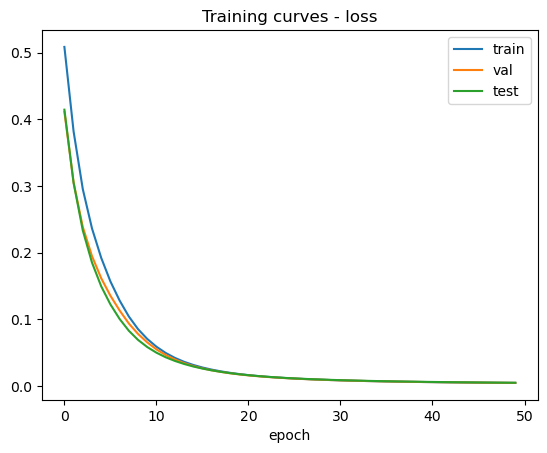

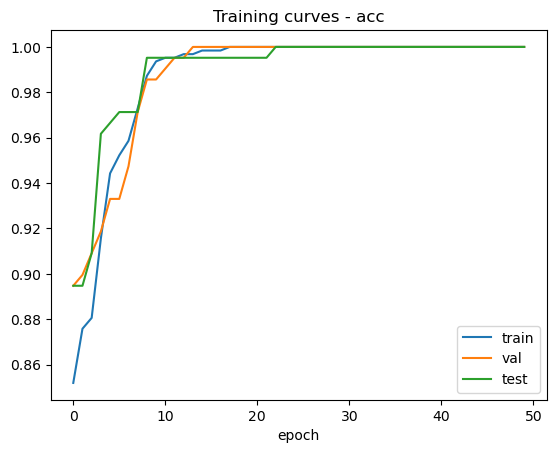

In [15]:
plot_training_curves(training_curves_one_layer, phases=['train', 'val', 'test'])


At default threshold:
 TN =   123,  FP =     1 -> N =   124
 FN =     0,  TP =    85 -> P =    85
TNR = 0.992, FPR = 0.008
FNR = 0.000, TPR = 1.000
ACC =  0.995


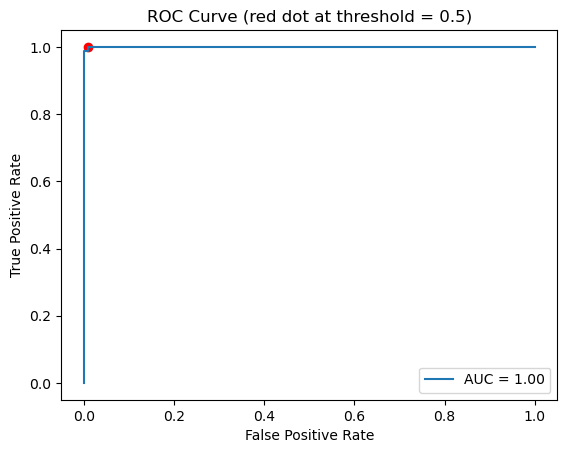

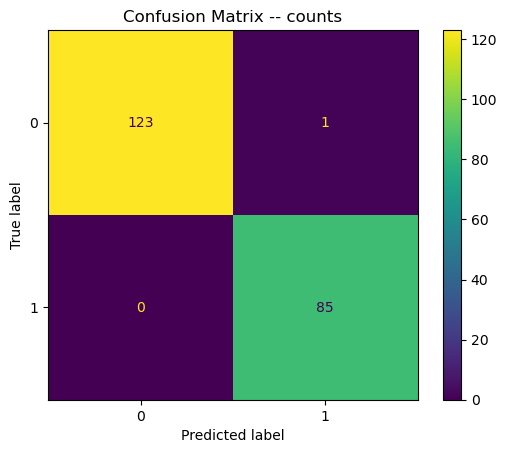

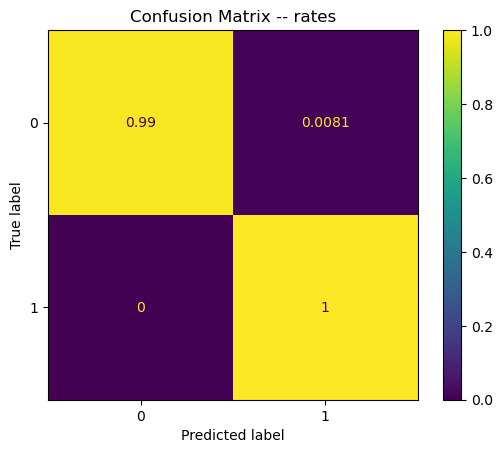

In [16]:
res = plot_metrics(one_layer_model, device, dataloaders, phase='test')

## Prevendo

In [17]:
# Importando o Dataset e adequando a base.

titanic_previsao = pd.read_csv('Dados/Titanic_Prever.csv')

# "Dumizando" a coluna Sex para ter um valor numerico final e convertendo o mesmo para 0 e 1
titanic_previsao = pd.get_dummies(titanic_previsao, columns=['Sex'], prefix='Sex')

titanic_previsao['Sex_female'] = (titanic_previsao['Sex_female'] == True).astype(int)
titanic_previsao['Sex_male'] = (titanic_previsao['Sex_male'] == True).astype(int)

# Para montar a base, vou selecionar as colunas abaixo que considero relevante para a sobrevivencia, Classe, Sexo, Idade, Num de Filhos, Parceiro, e se sobreviveu como saída
colunas_selecionadas = ['Pclass', 'Sex_female', 'Sex_male', 'Age', 'SibSp','Parch','Survived']

# Cria um novo DataFrame contendo apenas as colunas selecionadas
df_previsao = titanic_previsao[colunas_selecionadas]

df_previsao

,Pclass,Sex_female,Sex_male,Age,SibSp,Parch,Survived
0,1,0,1,45,1,1,1
1,1,1,0,41,1,1,1
2,1,1,0,5,0,0,1


In [42]:
input_data = torch.tensor(df_previsao.values, dtype=torch.float32)

# Certifique-se de que o modelo está em modo de avaliação
one_layer_model.eval()

# Faça a previsão
with torch.no_grad():
    predictions = one_layer_model(input_data)

# As previsões agora estão armazenadas em `predictions`
print(predictions)

# Aplica a função sigmoide
probabilities = torch.sigmoid(predictions)

# Converte as probabilidades para rótulos binários (0 ou 1)
binary_predictions = (probabilities >= 0.5).float()

# Exibe as previsões binárias
print(binary_predictions)

predicted_classes = torch.argmax(binary_predictions, dim=1)
print(predicted_classes)

tensor([[ 3.4509, -5.9423],
        [ 2.3025, -4.7168],
        [-0.1908, -0.1577]])
tensor([[1., 0.],
        [1., 0.],
        [0., 0.]])
tensor([0, 0, 0])


In [43]:
input_data = torch.tensor(df_previsao.values, dtype=torch.float32)

# Certifique-se de que o modelo está em modo de avaliação
two_layer_model.eval()

# Faça a previsão
with torch.no_grad():
    predictions = two_layer_model(input_data)

# As previsões agora estão armazenadas em `predictions`
print(predictions)

# Aplica a função sigmoide
probabilities = torch.sigmoid(predictions)

# Converte as probabilidades para rótulos binários (0 ou 1)
binary_predictions = (probabilities >= 0.5).float()

# Exibe as previsões binárias
print(binary_predictions)

predicted_classes = torch.argmax(binary_predictions, dim=1)
print(predicted_classes)

tensor([[ 13.2888, -12.6432],
        [ 10.3998, -10.0051],
        [ -1.2189,   0.7951]])
tensor([[1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([0, 0, 1])


In [44]:
input_data = torch.tensor(df_previsao.values, dtype=torch.float32)

# Certifique-se de que o modelo está em modo de avaliação
three_layer_model.eval()

# Faça a previsão
with torch.no_grad():
    predictions = three_layer_model(input_data)

# As previsões agora estão armazenadas em `predictions`
print(predictions)

# Aplica a função sigmoide
probabilities = torch.sigmoid(predictions)

# Converte as probabilidades para rótulos binários (0 ou 1)
binary_predictions = (probabilities >= 0.5).float()

# Exibe as previsões binárias
print(binary_predictions)

predicted_classes = torch.argmax(binary_predictions, dim=1)
print(predicted_classes)

tensor([[ 6.9461, -6.3870],
        [ 5.4117, -4.9330],
        [-0.5800,  0.8115]])
tensor([[1., 0.],
        [1., 0.],
        [0., 1.]])
tensor([0, 0, 1])
